In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mplt
import matplotlib as plt
import datetime as dati

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

In [145]:
train_csv = pd.read_csv("/home/federico/Git/datos-tp2-2c2020/data/friofrio/Train_TP2_Datos_2020-2C.csv",
        parse_dates = ['Account_Created_Date', 'Opportunity_Created_Date',
                       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date',
                       'Quote_Expiry_Date', 'Last_Modified_Date','Last_Activity' ])
# Limpio registros con muchos datos faltantes o inutiles
train_csv = train_csv.drop(columns= ['Prod_Category_A', 'Quote_Type',
                                 'Product_Category_B', 'Delivery_Terms',
                                 'Actual_Delivery_Date', 'Submitted_for_Approval',
                                 'Last_Activity','Price', 'Currency','Brand', 
                                 'Opportunity_Type', 'Size','Product_Type',
                                 'Account_Type', 'ASP_Currency', 'ASP_(converted)_Currency',
                                 'Total_Amount_Currency', 'Account_Name',
                                 'Opportunity_Name','Total_Taxable_Amount_Currency',
                                 'Product_Family', 'Product_Name'])

In [146]:
train_csv = train_csv.loc[(train_csv['Stage'] == 'Closed Won') | (train_csv['Stage'] == 'Closed Lost')]
train_csv['Oportunidad ganada'] = (train_csv['Stage'] == 'Closed Won').astype(int)

In [147]:
train_csv_numerics = train_csv.select_dtypes(include = np.number).fillna(0)

In [148]:
X = train_csv_numerics.drop(columns = 'Oportunidad ganada').fillna(0)
y = train_csv_numerics[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.drop(columns = ['Opportunity_ID', 'ID'])
X_test = X_test.drop(columns = ['Opportunity_ID', 'ID'])

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 4,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.40456575140620943

Text(0.5,1,'Distribucion de importancia de las features')

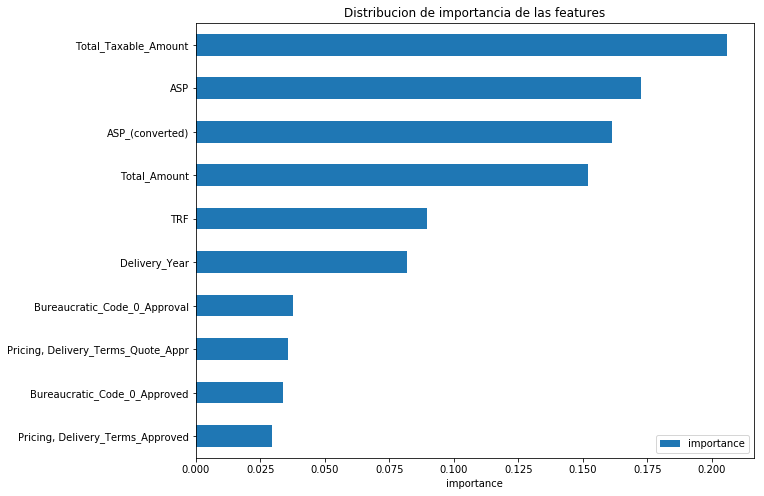

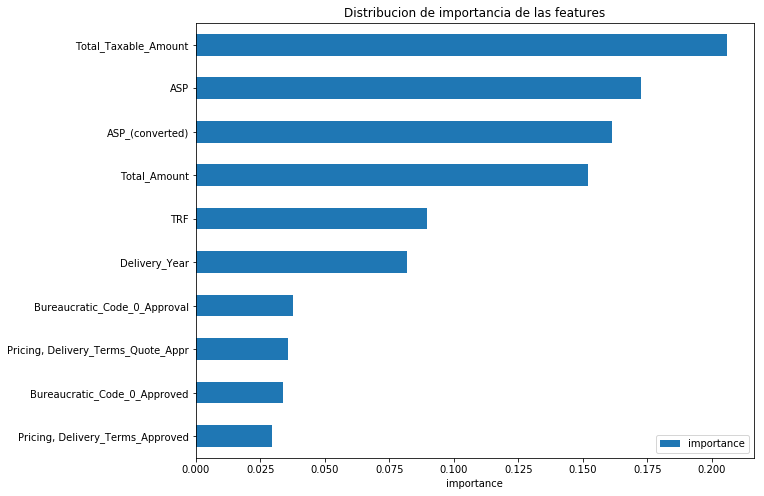

In [149]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nlargest(30, 'importance').sort_values(by = "importance")
ax_largest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_largest.set_xlabel("importance")
ax_largest.set_title("Distribucion de importancia de las features")

feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nsmallest(30, 'importance').sort_values(by = "importance")
ax_smallest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_smallest.set_xlabel("importance")
ax_smallest.set_title("Distribucion de importancia de las features")

In [150]:
train_csv_lucas = pd.read_csv('Features_agrupados_Train_Lucas.csv')

train_csv_lucas.drop(columns = ['Unnamed: 0'], inplace = True)

train_csv_lucas = train_csv_lucas.select_dtypes(include = np.number).fillna(0)

cols_to_use = train_csv_lucas.columns.difference(train_csv_numerics.columns)

train_csv_numerics_lucas = train_csv_numerics.replace([np.inf, -np.inf], np.nan)
train_csv_numerics_lucas = train_csv_numerics.join(
                    train_csv_lucas[cols_to_use], on = 'Opportunity_ID',
                    how = 'left').fillna(0)#.drop(columns = 'ID')
train_csv_numerics_lucas = train_csv_numerics_lucas.astype('float64')

train_csv_numerics_lucas = train_csv_numerics_lucas.replace([np.inf, -np.inf], np.nan)

In [151]:
train_csv_numerics_lucas.head()

,ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,...,Total_Amount_std,Total_Amount_sum,Total_Taxable_Amount_max,Total_Taxable_Amount_mean,Total_Taxable_Amount_median,Total_Taxable_Amount_min,Total_Taxable_Amount_std,Total_Taxable_Amount_sum,acount_age,delta_planed
0,27761.0,1.0,1.0,1.0,1.0,0.0,0.52,0.58817,2016.0,10.0,...,0.0,5272800.0,5272800.0,5272800.0,5272800.0,5272800.0,0.0,5272800.0,174.0,60.0
1,27760.0,0.0,0.0,0.0,0.0,1.0,0.53,0.59948,2016.0,0.0,...,0.0,48230.0,48230.0,48230.0,48230.0,48230.0,0.0,48230.0,174.0,2.0
2,27446.0,0.0,0.0,0.0,0.0,2.0,0.48,0.48000,2016.0,0.0,...,0.0,83865.6,83865.6,83865.6,83865.6,83865.6,0.0,83865.6,231.0,0.0
3,16808.0,1.0,0.0,1.0,0.0,3.0,0.53,0.53000,2018.0,14.0,...,0.0,7421881.5,7421881.5,7421881.5,7421881.5,7421881.5,0.0,7421881.5,864.0,58.0
4,16805.0,1.0,0.0,1.0,0.0,4.0,0.53,0.53000,2018.0,25.0,...,0.0,13357192.5,13357192.5,13357192.5,13357192.5,13357192.5,0.0,13357192.5,864.0,27.0


In [152]:
X = train_csv_numerics_lucas.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)
y = train_csv_numerics_lucas[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.40983984091280257

In [153]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.536208535940631
score test:  0.46956396997200905


Text(0.5,1,'Distribucion de importancia de las features')

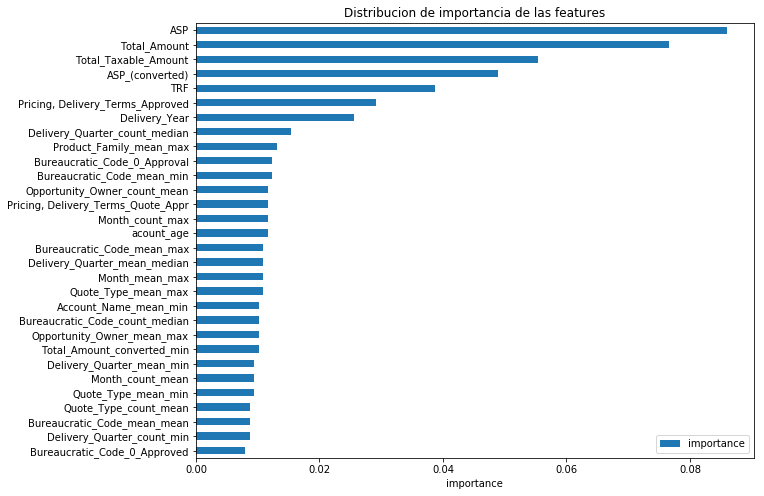

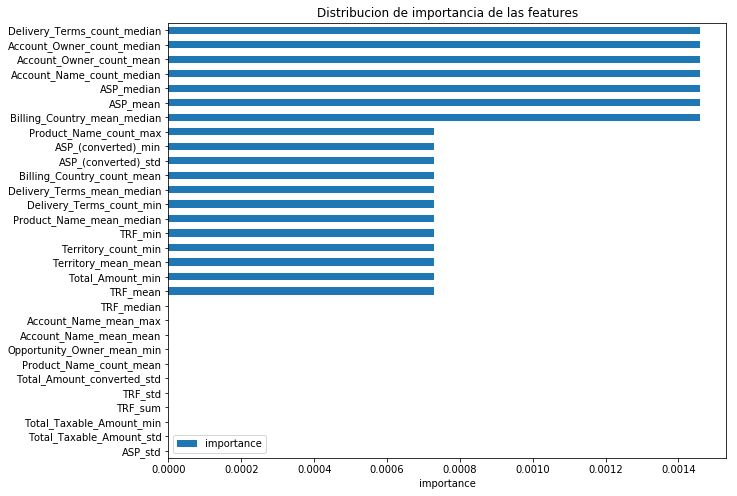

In [154]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nlargest(30, 'importance').sort_values(by = "importance")
ax_largest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_largest.set_xlabel("importance")
ax_largest.set_title("Distribucion de importancia de las features")

feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nsmallest(30, 'importance').sort_values(by = "importance")
ax_smallest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_smallest.set_xlabel("importance")
ax_smallest.set_title("Distribucion de importancia de las features")

In [155]:
train_csv_numerics_lucas_new = train_csv_numerics_lucas
train_csv_numerics_lucas_new['Precio necesita aprobacion'] = \
            (train_csv_numerics_lucas_new['Pricing, Delivery_Terms_Quote_Appr'] == 1).astype(int)
train_csv_numerics_lucas_new['Precio aprobado'] =\
            ((train_csv_numerics_lucas_new['Pricing, Delivery_Terms_Approved'] == 1)|\
            (train_csv_numerics_lucas_new['Pricing, Delivery_Terms_Quote_Appr'] == 0)).astype(int)
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new.drop(columns = ['Pricing, Delivery_Terms_Quote_Appr',
                                                    'Pricing, Delivery_Terms_Approved'])

aux = train_csv_numerics_lucas_new.groupby('Opportunity_ID')\
    .agg({'Precio necesita aprobacion':'sum', 'Precio aprobado':'sum'})
aux.reset_index(inplace=True)
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new\
                            .drop(columns = ['Precio aprobado','Precio necesita aprobacion'])\
                            .merge(aux, on = 'Opportunity_ID', how = 'left')
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new.select_dtypes(include = np.number).fillna(0)

train_csv_numerics_lucas_new['Necesita codigo burocratico 0'] = \
            (train_csv_numerics_lucas_new['Bureaucratic_Code_0_Approval'] == 1).astype(int)
train_csv_numerics_lucas_new['Codigo burocratico 0 aprobado'] =\
            ((train_csv_numerics_lucas_new['Bureaucratic_Code_0_Approved'] == 1)|\
            (train_csv_numerics_lucas_new['Bureaucratic_Code_0_Approval'] == 0)).astype(int)
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new.drop(columns = ['Bureaucratic_Code_0_Approved',
                                                    'Bureaucratic_Code_0_Approval'])

aux = train_csv_numerics_lucas_new.groupby('Opportunity_ID')\
    .agg({'Necesita codigo burocratico 0':'sum', 'Codigo burocratico 0 aprobado':'sum'})
aux.reset_index(inplace=True)
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new\
                            .drop(columns = ['Necesita codigo burocratico 0','Codigo burocratico 0 aprobado'])\
                            .merge(aux, on = 'Opportunity_ID', how = 'left')
train_csv_numerics_lucas_new = train_csv_numerics_lucas_new.select_dtypes(include = np.number).fillna(0)

#train_csv_numerics_lucas_new.drop(columns = ['Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved'], inplace = True)
train_csv_numerics_lucas_new.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Oportunidad ganada,ASP_(converted)_max,...,Total_Taxable_Amount_median,Total_Taxable_Amount_min,Total_Taxable_Amount_std,Total_Taxable_Amount_sum,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Necesita codigo burocratico 0,Codigo burocratico 0 aprobado
0,27761.0,0.0,0.52,0.58817,2016.0,10.0,5272800.0,5272800.0,0.0,0.58817,...,5272800.0,5272800.0,0.0,5272800.0,174.0,60.0,1,1,1,1
1,27760.0,1.0,0.53,0.59948,2016.0,0.0,48230.0,48230.0,1.0,0.59948,...,48230.0,48230.0,0.0,48230.0,174.0,2.0,0,1,0,1
2,27446.0,2.0,0.48,0.48000,2016.0,0.0,83865.6,83865.6,1.0,0.48000,...,83865.6,83865.6,0.0,83865.6,231.0,0.0,0,1,0,1
3,16808.0,3.0,0.53,0.53000,2018.0,14.0,7421881.5,7421881.5,0.0,0.53000,...,7421881.5,7421881.5,0.0,7421881.5,864.0,58.0,1,0,1,0
4,16805.0,4.0,0.53,0.53000,2018.0,25.0,13357192.5,13357192.5,0.0,0.53000,...,13357192.5,13357192.5,0.0,13357192.5,864.0,27.0,1,0,1,0


In [156]:
X = train_csv_numerics_lucas_new.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)

y = train_csv_numerics_lucas_new[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.39048858816554255

In [157]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.5587456652275625
score test:  0.49553438046036535


Text(0.5,1,'Distribucion de importancia de las features')

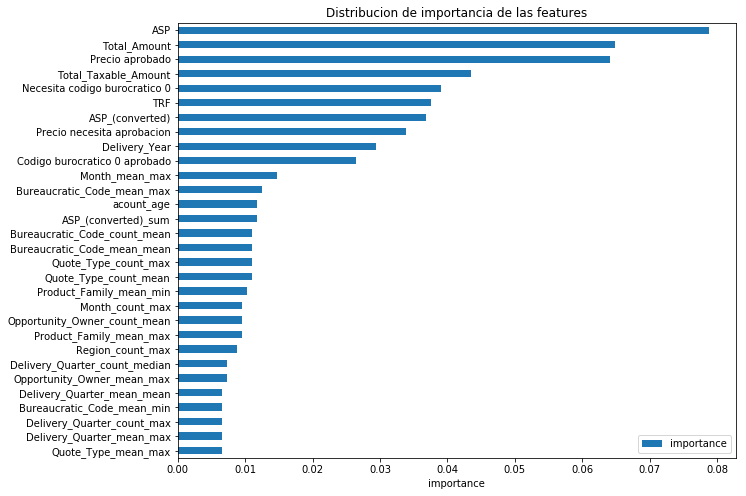

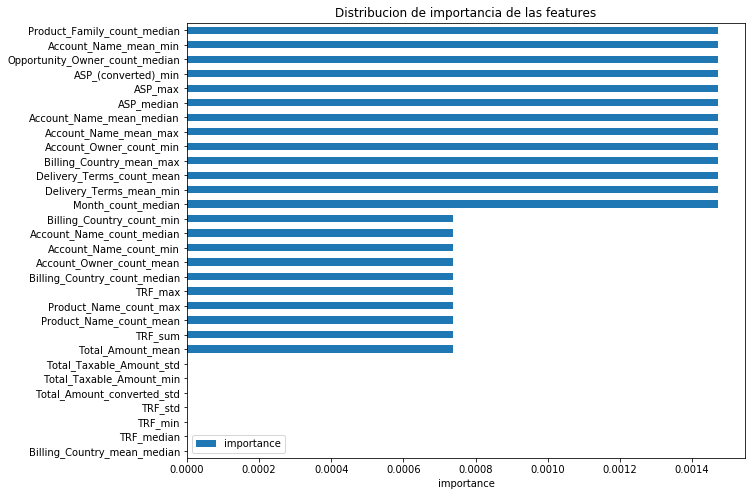

In [158]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nlargest(30, 'importance').sort_values(by = "importance")
ax_largest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_largest.set_xlabel("importance")
ax_largest.set_title("Distribucion de importancia de las features")

feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nsmallest(30, 'importance').sort_values(by = "importance")
ax_smallest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_smallest.set_xlabel("importance")
ax_smallest.set_title("Distribucion de importancia de las features")

In [159]:
pivoted = train_csv[['Opportunity_ID','Delivery_Quarter']].pivot_table(index = 'Opportunity_ID',columns = 'Delivery_Quarter',aggfunc = {'Delivery_Quarter':'count'}).fillna(0).reset_index()

pivoted = pivoted.set_index('Opportunity_ID')
pivoted.columns = pivoted.columns.droplevel(0)
pivoted = pivoted.reset_index()

quarter_numeric = train_csv[['ID','Delivery_Quarter']]
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q1'] = 1
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q2'] = 2
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q3'] = 3
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q4'] = 4

train_csv_numerics_quarter = train_csv_numerics_lucas_new.merge(pivoted, on = 'Opportunity_ID')
train_csv_numerics_quarter = train_csv_numerics_quarter.merge(quarter_numeric, on = 'ID')

/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/federico/.local/lib/python2.7/site-packa

In [160]:
train_csv_numerics_quarter.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,Oportunidad ganada,ASP_(converted)_max,...,delta_planed,Precio necesita aprobacion,Precio aprobado,Necesita codigo burocratico 0,Codigo burocratico 0 aprobado,Q1,Q2,Q3,Q4,Delivery_Quarter
0,27761.0,0.0,0.52,0.58817,2016.0,10.0,5272800.0,5272800.0,0.0,0.58817,...,60.0,1,1,1,1,0.0,1.0,0.0,0.0,2
1,27760.0,1.0,0.53,0.59948,2016.0,0.0,48230.0,48230.0,1.0,0.59948,...,2.0,0,1,0,1,1.0,0.0,0.0,0.0,1
2,27446.0,2.0,0.48,0.48000,2016.0,0.0,83865.6,83865.6,1.0,0.48000,...,0.0,0,1,0,1,1.0,0.0,0.0,0.0,1
3,16808.0,3.0,0.53,0.53000,2018.0,14.0,7421881.5,7421881.5,0.0,0.53000,...,58.0,1,0,1,0,1.0,0.0,0.0,0.0,1
4,16805.0,4.0,0.53,0.53000,2018.0,25.0,13357192.5,13357192.5,0.0,0.53000,...,27.0,1,0,1,0,1.0,0.0,0.0,0.0,1


In [161]:
X = train_csv_numerics_quarter.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)

y = train_csv_numerics_quarter[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr.fit(X_train, y_train)

preds = xgbr.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.385577531087234

In [162]:
print 'score train: ' + str(xgbr.score(X_train, y_train))
print 'score test:  ' + str(xgbr.score(X_test, y_test))

score train: 0.5567788583924065
score test:  0.5010186253606435


Text(0.5,1,'Distribucion de importancia de las features')

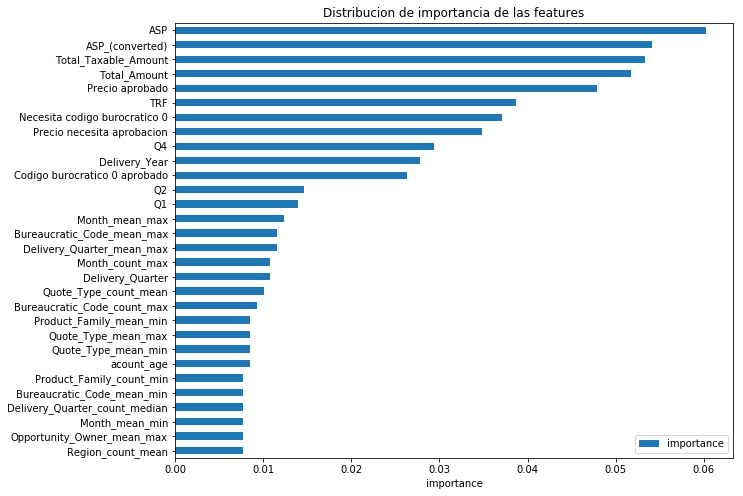

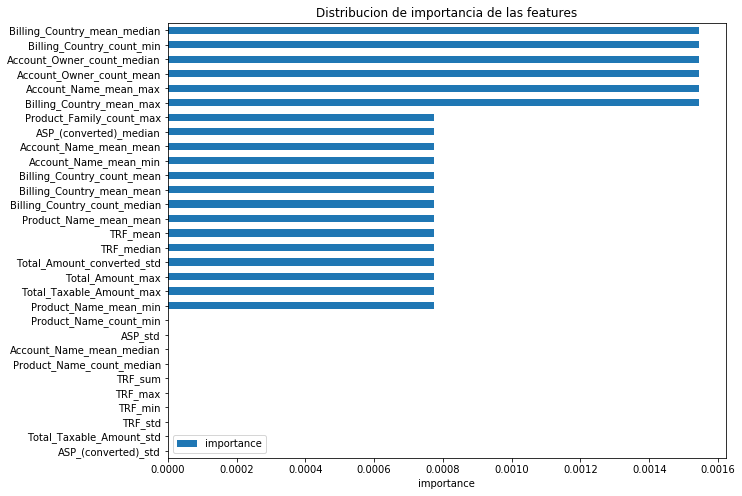

In [163]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nlargest(30, 'importance').sort_values(by = "importance")
ax_largest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_largest.set_xlabel("importance")
ax_largest.set_title("Distribucion de importancia de las features")

feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nsmallest(30, 'importance').sort_values(by = "importance")
ax_smallest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_smallest.set_xlabel("importance")
ax_smallest.set_title("Distribucion de importancia de las features")

In [169]:
feature_importances = \
    pd.DataFrame(xgbr.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance'])
list_least_important = list(feature_importances.loc[feature_importances["importance"]== 0].reset_index()['index'])
list_least_important

['ASP_(converted)_std',
 'ASP_std',
 'Account_Name_mean_median',
 'Product_Name_count_median',
 'Product_Name_count_min',
 'TRF_max',
 'TRF_min',
 'TRF_std',
 'TRF_sum',
 'Total_Taxable_Amount_std']

In [167]:
feature_importances.loc[feature_importances["importance"]== 0]

,importance
ASP_(converted)_std,0.0
ASP_std,0.0
Account_Name_mean_median,0.0
Product_Name_count_median,0.0
Product_Name_count_min,0.0
TRF_max,0.0
TRF_min,0.0
TRF_std,0.0
TRF_sum,0.0
Total_Taxable_Amount_std,0.0


In [170]:
dropped = train_csv_numerics_quarter.drop(columns = 
['ASP_(converted)_std',
 'ASP_std',
 'Account_Name_mean_median',
 'Product_Name_count_median',
 'Product_Name_count_min',
 'TRF_max',
 'TRF_min',
 'TRF_std',
 'TRF_sum',
 'Total_Taxable_Amount_std'])

In [171]:
X = dropped.drop(columns = ['Oportunidad ganada','ID', 'Opportunity_ID']).fillna(0)

y = dropped[['Oportunidad ganada']].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

xgbr_dropped = xgb.XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 3,
    alpha = 10,
    n_estimators = 200,
    objective = 'binary:logistic')

xgbr_dropped.fit(X_train, y_train)

preds = xgbr_dropped.predict(X_test)

log_loss(y_test, preds, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.386841935243962

In [172]:
print 'score train: ' + str(xgbr_dropped.score(X_train, y_train))
print 'score test:  ' + str(xgbr_dropped.score(X_test, y_test))

score train: 0.5567396184676228
score test:  0.5013798702956624


Text(0.5,1,'Distribucion de importancia de las features')

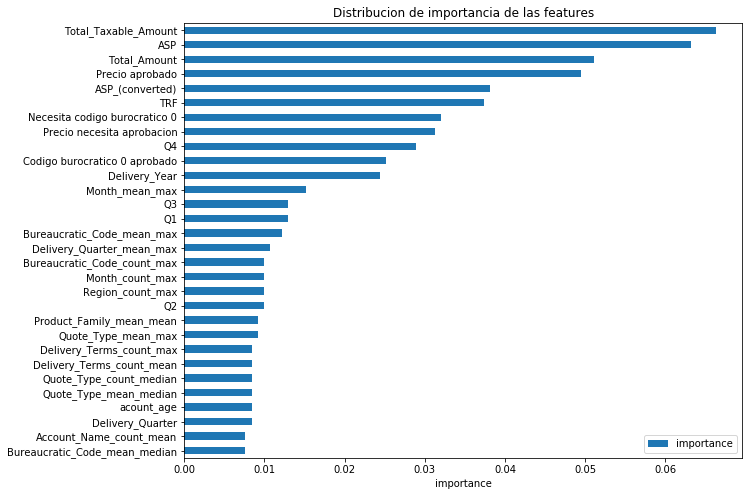

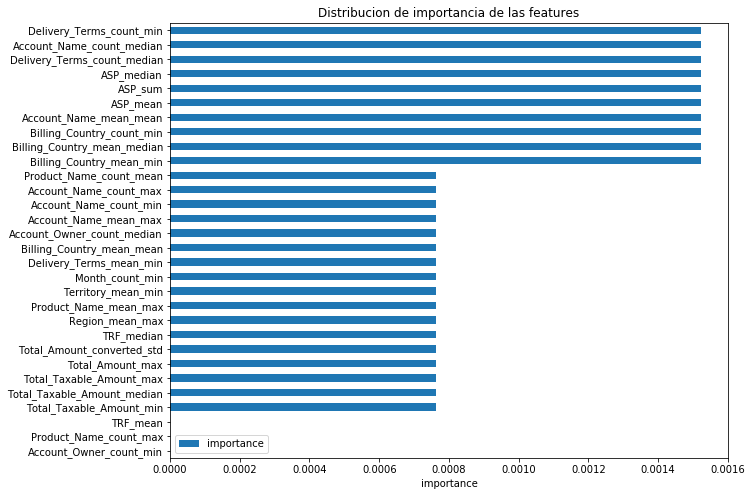

In [173]:
feature_importances = \
    pd.DataFrame(xgbr_dropped.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nlargest(30, 'importance').sort_values(by = "importance")
ax_largest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_largest.set_xlabel("importance")
ax_largest.set_title("Distribucion de importancia de las features")

feature_importances = \
    pd.DataFrame(xgbr_dropped.feature_importances_, \
                 index = X_train.columns, \
                 columns = ['importance']).nsmallest(30, 'importance').sort_values(by = "importance")
ax_smallest = feature_importances.plot(kind='barh', figsize=(10, 8))
ax_smallest.set_xlabel("importance")
ax_smallest.set_title("Distribucion de importancia de las features")

In [324]:
test_csv = pd.read_csv("/home/federico/Git/datos-tp2-2c2020/data/friofrio/Test_TP2_Datos_2020-2C.csv",
        parse_dates = ['Account_Created_Date', 'Opportunity_Created_Date',
                       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date',
                       'Quote_Expiry_Date', 'Last_Modified_Date','Last_Activity' ])
# Limpio registros con muchos datos faltantes o inutiles
test_csv = test_csv.drop(columns= ['Prod_Category_A', 'Quote_Type',
                                 'Product_Category_B', 'Delivery_Terms',
                                 'Actual_Delivery_Date', 'Submitted_for_Approval',
                                 'Last_Activity','Price', 'Currency','Brand', 
                                 'Opportunity_Type', 'Size','Product_Type',
                                 'Account_Type', 'ASP_Currency', 'ASP_(converted)_Currency',
                                 'Total_Amount_Currency', 'Account_Name',
                                 'Opportunity_Name','Total_Taxable_Amount_Currency',
                                 'Product_Family', 'Product_Name'])

In [325]:
X_test_to_submit = test_csv.select_dtypes(include = np.number).fillna(0)
cols_to_use = train_csv_lucas.columns.difference(X_test_to_submit.columns)
X_test_to_submit = X_test_to_submit.join(
                    train_csv_lucas[cols_to_use], on = 'Opportunity_ID',
                    how = 'left').fillna(0)

X_test_to_submit['Precio necesita aprobacion'] = (X_test_to_submit['Pricing, Delivery_Terms_Quote_Appr'] == 1)
X_test_to_submit['Precio aprobado'] = (X_test_to_submit['Pricing, Delivery_Terms_Approved'] == 1)
X_test_to_submit['Precio necesita aprobacion'] = X_test_to_submit['Precio necesita aprobacion'].astype(int)
X_test_to_submit['Precio aprobado'] = X_test_to_submit['Precio aprobado'].astype(int)
X_test_to_submit = X_test_to_submit.drop(columns = ['Pricing, Delivery_Terms_Quote_Appr',
                                                    'Pricing, Delivery_Terms_Approved'])

a = X_test_to_submit.groupby('Opportunity_ID')\
    .agg({'Precio necesita aprobacion':'sum', 'Precio aprobado':'sum'})
a.reset_index(inplace=True)
X_test_to_submit = X_test_to_submit\
                            .drop(columns = ['Precio aprobado','Precio necesita aprobacion'])\
                            .merge(a, on = 'Opportunity_ID', how = 'left')
X_test_to_submit = X_test_to_submit.select_dtypes(include = np.number).fillna(0)


X_test_to_submit['Necesita codigo burocratico 0'] = \
            (X_test_to_submit['Bureaucratic_Code_0_Approval'] == 1).astype(int)
X_test_to_submit['Codigo burocratico 0 aprobado'] =\
            ((X_test_to_submit['Bureaucratic_Code_0_Approved'] == 1)|\
            (X_test_to_submit['Bureaucratic_Code_0_Approval'] == 0)).astype(int)
X_test_to_submit = X_test_to_submit.drop(columns = ['Bureaucratic_Code_0_Approved',
                                                    'Bureaucratic_Code_0_Approval'])

aux = X_test_to_submit.groupby('Opportunity_ID')\
    .agg({'Necesita codigo burocratico 0':'sum', 'Codigo burocratico 0 aprobado':'sum'})
aux.reset_index(inplace=True)
X_test_to_submit = X_test_to_submit\
                            .drop(columns = ['Necesita codigo burocratico 0','Codigo burocratico 0 aprobado'])\
                            .merge(aux, on = 'Opportunity_ID', how = 'left')
X_test_to_submit = X_test_to_submit.select_dtypes(include = np.number).fillna(0)


pivoted = test_csv[['Opportunity_ID','Delivery_Quarter']].pivot_table(
                    index = 'Opportunity_ID',
                    columns = 'Delivery_Quarter',
                    aggfunc = {'Delivery_Quarter':'count'})\
                    .fillna(0).reset_index()

pivoted = pivoted.set_index('Opportunity_ID')
pivoted.columns = pivoted.columns.droplevel(0)
pivoted = pivoted.reset_index()

quarter_numeric = test_csv[['ID','Delivery_Quarter']]
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q1'] = 1
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q2'] = 2
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q3'] = 3
quarter_numeric['Delivery_Quarter'].loc[quarter_numeric['Delivery_Quarter'] == 'Q4'] = 4

X_test_to_submit = X_test_to_submit.merge(pivoted, on = 'Opportunity_ID')
X_test_to_submit = X_test_to_submit.merge(quarter_numeric, on = 'ID')

/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/federico/.local/lib/python2.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set o

In [326]:
X_test_to_submit.head()

,ID,Opportunity_ID,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,ASP_(converted)_max,ASP_(converted)_mean,...,delta_planed,Precio necesita aprobacion,Precio aprobado,Necesita codigo burocratico 0,Codigo burocratico 0 aprobado,Q1,Q2,Q3,Q4,Delivery_Quarter
0,6140,10689,0.325,0.36761,2019,0,162240.0,367419.0,0.0,0.0,...,0.0,3,3,3,3,0.0,3.0,0.0,0.0,2
1,6146,10689,0.320,0.36195,2019,0,78624.0,367419.0,0.0,0.0,...,0.0,3,3,3,3,0.0,3.0,0.0,0.0,2
2,6151,10689,0.275,0.31105,2019,0,126555.0,367419.0,0.0,0.0,...,0.0,3,3,3,3,0.0,3.0,0.0,0.0,2
3,6118,10690,0.325,0.36761,2019,1,243360.0,757783.5,0.0,0.0,...,0.0,5,5,5,5,0.0,5.0,0.0,0.0,2
4,6124,10690,0.320,0.36195,2019,0,157248.0,757783.5,0.0,0.0,...,0.0,5,5,5,5,0.0,5.0,0.0,0.0,2


In [327]:
preds_to_submit = xgbr.predict(X_test_to_submit.drop(columns = ['Opportunity_ID','ID']))

X_test_to_submit['Target'] = preds_to_submit.astype('float32')

result = X_test_to_submit[['Opportunity_ID','Target']].groupby(['Opportunity_ID']).mean()
result.reset_index(inplace=True)

result.to_csv('predicciones_XGB.csv', index = False)

In [176]:
results_rf = pd.read_csv('predicciones_RF.csv')

In [177]:
result_merged = results_rf.merge(result, left_index = True, right_index = True)
result_merged.head()

,Opportunity_ID_x,Target_x,Opportunity_ID_y,Target_y
0,10689,0.635470,10689,0.652051
1,10690,0.621803,10690,0.524487
2,10691,0.803814,10691,0.837397
3,10692,0.701912,10692,0.531157
4,10693,0.642688,10693,0.674004


In [178]:
result_merged['Target'] = (result_merged['Target_x'] + result_merged['Target_y'])/2
result_merged = result_merged.drop(columns = ['Opportunity_ID_y', 'Target_x', 'Target_y'])
result_merged = result_merged.rename(columns = {'Opportunity_ID_x':'Opportunity_ID'})
result_merged.head()

,Opportunity_ID,Target
0,10689,0.643761
1,10690,0.573145
2,10691,0.820606
3,10692,0.616534
4,10693,0.658346


In [179]:
result_merged.to_csv('predicciones_RF_XGB_combinadas.csv', index = False)

In [251]:
X_train.head()

,ASP,ASP_(converted),Delivery_Year,TRF,Total_Amount,Total_Taxable_Amount,ASP_(converted)_max,ASP_(converted)_mean,ASP_(converted)_median,ASP_(converted)_min,...,acount_age,delta_planed,Precio necesita aprobacion,Precio aprobado,Q1,Q2,Q3,Q4,count_lost,count_won
9798,0.390,0.390,2017.0,0.0,79170.0,79170.0,0.58437,0.58437,0.58437,0.58437,...,925.0,0.0,1,1,0.0,0.0,0.0,1.0,0.0,0.0
10709,0.000,0.000,2017.0,0.0,6200.0,620175.0,0.40154,0.40154,0.40154,0.40154,...,37.0,0.0,6,6,0.0,0.0,0.0,6.0,0.0,0.0
5593,0.365,0.365,2017.0,21.0,7703325.0,0.0,0.41850,0.41850,0.41850,0.41850,...,636.0,4.0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
16304,0.000,0.000,2016.0,0.0,12800.0,6995400.0,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,6,0,0.0,6.0,0.0,0.0,0.0,0.0
4725,0.000,0.000,2016.0,0.0,6200.0,628000.0,0.39000,0.39000,0.39000,0.39000,...,0.0,30.0,5,5,0.0,0.0,0.0,5.0,0.0,0.0


In [261]:
X_train.columns.difference(X_test_to_submit.columns)

Index([u'ASP_sum', u'Account_Owner_count_max', u'Account_Owner_count_min',
       u'Product_Family_count_mean', u'Product_Family_count_median',
       u'Product_Family_mean_min', u'TRF_max', u'TRF_mean', u'TRF_std',
       u'TRF_sum'],
      dtype='object')